In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset, read_pred_csv
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

from torch import Tensor
from collections import OrderedDict, defaultdict
import copy

import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
DEBUG = False

# training cfg
validation_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [224, 224], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'valid_data_loader': {
        'key': "scenes/validate_chopped_100/validate.zarr",
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 0
    },

    ## Valid params
    'valid_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 1000
    }
}

common_cfg = {
    'seed': 500,
    'output_dir': './outputs/1011_2/',
    'epoch': 2,
    'train_step': 5 if DEBUG else 500,
    'valid_step': 5 if DEBUG else 50,
    'train_max': 12,
    'learning_rate': 1e-3
}


In [3]:
OUTPUT_DIR = common_cfg['output_dir']
INPUT_ROOT = Path('/home/knikaido/work/Lyft/data/')
DATA_DIR = INPUT_ROOT / 'lyft-motion-prediction-autonomous-vehicles/'

In [4]:
pred_path = f"{OUTPUT_DIR}/pred_1114_3.csv"

In [5]:
eval_gt_path = str(f"{str(DATA_DIR)}/scenes/validate_chopped_100/gt.csv")

In [6]:
output = pd.read_csv(pred_path)
output.sort_values(['timestamp', 'track_id'], inplace=True)
output.reset_index(inplace=True, drop=True)
output.append(output)

,timestamp,track_id,conf_0,conf_1,conf_2,conf_3,conf_4,conf_5,conf_6,coord_x00,...,coord_x645,coord_y645,coord_x646,coord_y646,coord_x647,coord_y647,coord_x648,coord_y648,coord_x649,coord_y649
0,1574364399902601396,1,0.047053,0.083952,0.163283,0.156911,0.294436,0.210383,0.043982,0.42688,...,11.09499,21.77894,11.21524,21.99968,11.36075,22.22992,11.48403,22.44345,11.54836,22.70059
1,1574364399902601396,3,0.078844,0.123129,0.108639,0.174070,0.287955,0.172817,0.054546,0.43202,...,11.76659,24.49415,11.90160,24.78090,12.04869,25.10051,12.17769,25.39488,12.33285,25.65205
2,1574364424902827486,2,0.141832,0.158801,0.048074,0.199844,0.321923,0.107202,0.022323,0.71953,...,26.61708,40.94997,27.06529,41.69657,27.53708,42.45990,27.99220,43.15443,28.42129,43.94967
3,1574364449901934626,836,0.047732,0.130756,0.083317,0.262717,0.314418,0.124960,0.036099,-0.44827,...,-9.82472,-11.46109,-9.93722,-11.50164,-10.02210,-11.60464,-10.22642,-11.64722,-10.39608,-11.73745
4,1574364474902117814,1,0.082070,0.123042,0.048595,0.249737,0.349004,0.136453,0.011100,0.46782,...,16.30347,33.85537,16.53402,34.22279,16.64886,34.66364,16.81849,35.04360,17.20812,35.24193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94689,1584140351702477836,8,0.114697,0.134964,0.062437,0.197809,0.321893,0.123973,0.044228,-0.65334,...,-24.71863,-39.68674,-25.13796,-40.46288,-25.61457,-41.24128,-26.03961,-41.94625,-26.42937,-42.80265
94690,1584140451301713374,364,0.128899,0.161503,0.028702,0.212091,0.373220,0.078062,0.017524,0.92162,...,34.02097,52.32861,34.55973,53.20836,35.12270,54.10704,35.65539,54.95577,36.20578,55.82801
94691,1584140451301713374,494,0.436630,0.313141,0.017130,0.117426,0.091378,0.012543,0.011751,-0.81591,...,-6.77751,3.75855,-6.93731,3.75438,-7.07553,3.78984,-7.20260,3.88132,-7.26237,3.93159
94692,1584140476302704606,1,0.082512,0.153735,0.095225,0.183323,0.253942,0.146565,0.084698,-0.44613,...,-9.86491,-13.65429,-9.92991,-13.73950,-10.05256,-13.81816,-10.14766,-13.91316,-10.18508,-14.03438


In [7]:
t_predicts = []
t_confs = []

In [8]:
for i in tqdm(range(94694)):
    predicts = []
    confs = []
    confs.append(output.loc[i, 'conf_0'])
    confs.append(output.loc[i, 'conf_1'])
    confs.append(output.loc[i, 'conf_2'])
    confs.append(output.loc[i, 'conf_3'])
    confs.append(output.loc[i, 'conf_4'])
    confs.append(output.loc[i, 'conf_5'])
    confs.append(output.loc[i, 'conf_6'])
    predicts.append(output.loc[i, 'coord_x00':'coord_y049'].values)
    predicts.append(output.loc[i, 'coord_x10':'coord_y149'].values)
    predicts.append(output.loc[i, 'coord_x20':'coord_y249'].values)
    predicts.append(output.loc[i, 'coord_x30':'coord_y349'].values)
    predicts.append(output.loc[i, 'coord_x40':'coord_y449'].values)
    predicts.append(output.loc[i, 'coord_x50':'coord_y549'].values)
    predicts.append(output.loc[i, 'coord_x60':'coord_y649'].values)
    t_predicts.append(predicts)
    t_confs.append(confs)

100%|██████████| 94694/94694 [05:47<00:00, 272.15it/s]


In [9]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [10]:
def calc_distance(coord1, coord2):
    coord1 = coord1.reshape(-1, 2)
    coord2= coord2.reshape(-1, 2)
    distance = 0
    cos = 0
    for i in range(len(coord1)):
        cos += cos_sim(coord2[i], coord1[i])
        distance += pow(coord2[i, 0] - coord1[i, 0], 2) + pow(coord2[i, 1] - coord1[i, 1], 2)
        
    return cos / len(coord1), np.sqrt(distance)
    

In [11]:
def decide_preds(tmp_predicts, tmp_conf, thre=30):
    
    
    predicts = copy.deepcopy(tmp_predicts)
    confs = copy.deepcopy(tmp_conf)
    
    ans_preds = []
    ans_confs = []
    
    for i in range(3):
        ind = np.argmax(confs)
        pre1 = predicts[ind]
        ans_preds.append(pre1)
        ans_confs.append(confs[ind])
        predicts.pop(ind)
        confs.pop(ind)

        predicts_ = []
        confs_ = []
        for i in range(len(predicts)):
            angle, dist = calc_distance(pre1, np.array(predicts[i]))
            if(dist > thre):
                predicts_.append(predicts[i])
                confs_.append(confs[i])
                
        if(len(confs_)<3):
            junban = np.array(tmp_conf).argsort()[::-1]
            ans_preds = [tmp_predicts[junban[0]], tmp_predicts[junban[1]], tmp_predicts[junban[2]]]
            ans_confs = [tmp_conf[junban[0]], tmp_conf[junban[1]], tmp_conf[junban[2]]]
            ans_confs = ans_confs / np.sum(ans_confs)
            
            return ans_preds, ans_confs, 0
                        
        predicts = predicts_
        confs = confs_
        
    ans_confs = ans_confs / np.sum(ans_confs)
    return ans_preds, ans_confs, 1
        

In [12]:
# prepre, concon = decide_preds(t_predicts[0], t_confs[0])

In [13]:
# count = 0
# for j in tqdm(range(94694)):
#     prepre, concon, c_ = decide_preds(t_predicts[j], t_confs[j])
#     count += c_
    
#     if(c_ == 0): break

In [14]:
# for i in range(7):
#     plt.plot(t_predicts[j][i][::2], t_predicts[j][i][1::2])

In [15]:
# for i in range(3):
#     plt.plot(prepre[i][::2], prepre[i][1::2])

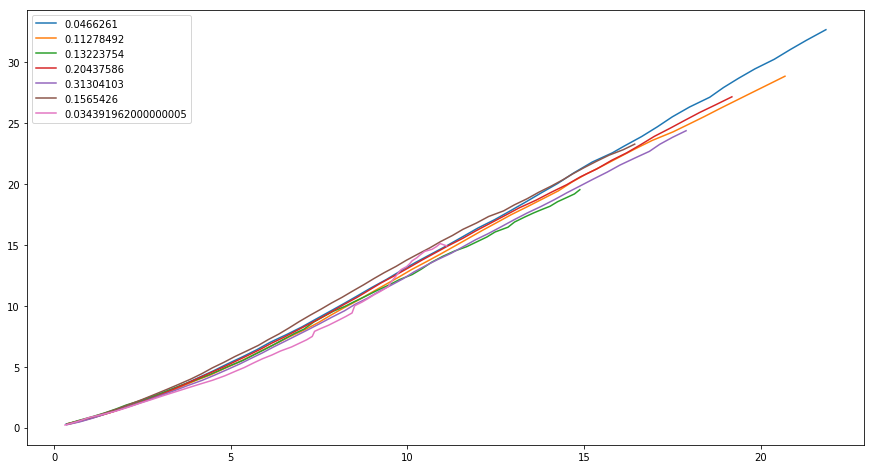

In [44]:
ind = 5555
plt.figure(figsize=(15,8))
for i, p in enumerate(t_predicts[ind]):
    plt.plot(p[::2], p[1::2], label=t_confs[ind][i])
plt.legend()

In [27]:
ans_output = pd.read_csv(str(OUTPUT_DIR)+'pred_1010.csv')
ans_output.sort_values(['timestamp', 'track_id'], inplace=True)
ans_output.reset_index(inplace=True, drop=True)
ans_conf = ans_output.loc[:, 'conf_0':'conf_2']
ans_coord= ans_output.loc[:, 'coord_x00':]

In [28]:
count = 0
for j in tqdm(range(len(ans_output))):
    prepre, concon, c_ = decide_preds(t_predicts[j], t_confs[j])
    count += c_

    ans_conf.iloc[j] = concon
    ans_coord.iloc[j] = np.array(prepre).reshape(-1)
count

100%|██████████| 94694/94694 [13:24<00:00, 117.71it/s]


32492

In [29]:
ans_output.loc[:, 'conf_0':'conf_2'] = ans_conf
ans_output.loc[:, 'coord_x00':] = ans_coord

In [30]:
ans_output.to_csv(str(OUTPUT_DIR)+'pred_7_to_5.csv', index=False)
pred_path_ = str(OUTPUT_DIR)+'pred_7_to_5.csv'
ans_output

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_x245,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249
0,1574364399902601396,1,0.444949,0.317928,0.237123,0.36987,0.75126,0.68614,1.47587,1.04838,...,17.86838,31.23986,18.26977,31.62543,18.67192,32.09402,19.05049,32.52573,19.42278,32.90942
1,1574364399902601396,3,0.453586,0.274194,0.272221,0.41560,0.77517,0.78901,1.55778,1.18962,...,14.88321,28.87667,15.13418,29.32071,15.36436,29.73073,15.60717,30.13920,15.83519,30.50052
2,1574364424902827486,2,0.473021,0.293642,0.233336,0.74902,1.03984,1.37890,2.08482,2.09137,...,35.57885,53.51735,36.40336,54.67818,37.21189,55.84386,38.02174,56.98137,38.85263,58.17807
3,1574364449901934626,836,0.444161,0.371126,0.184713,-0.37059,-0.49570,-0.73243,-0.95177,-1.10034,...,-23.59312,-33.75745,-24.13905,-34.58591,-24.68149,-35.46200,-25.21697,-36.33753,-25.77842,-37.16860
4,1574364474902117814,1,0.474710,0.339689,0.185601,0.60715,0.93577,1.19114,1.85547,1.74593,...,14.70204,48.11919,14.78412,49.24353,14.80258,50.37782,14.89822,51.42462,14.88793,52.47351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94689,1584140351702477836,8,0.491691,0.302152,0.206157,-0.66357,-0.96932,-1.19221,-1.91310,-1.82573,...,-36.47452,-56.04315,-37.43965,-57.36883,-38.38318,-58.71496,-39.33154,-60.07148,-40.32399,-61.46592
94690,1584140451301713374,364,0.499750,0.283994,0.216256,0.97075,1.33416,1.78556,2.68481,2.70128,...,44.52605,67.49254,45.53467,68.95166,46.52965,70.40350,47.54325,71.84586,48.56996,73.35403
94691,1584140451301713374,494,0.503496,0.361095,0.135409,-0.81591,0.63995,-1.70253,1.28447,-2.67831,...,-16.92945,11.74073,-16.85232,11.88365,-17.01656,11.98767,-16.94179,12.06706,-16.87635,12.11766
94692,1584140476302704606,1,0.429681,0.310192,0.260127,-0.40417,-0.61299,-0.75274,-1.20158,-1.14941,...,-25.53566,-27.82966,-26.22359,-28.28913,-26.88558,-28.76627,-27.56867,-29.28312,-28.25459,-29.74748


In [31]:
metrics = compute_metrics_csv(eval_gt_path, pred_path_, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 54.4714600760631
time_displace [0.04882651 0.077155   0.10445592 0.12403204 0.14783763 0.16913939
 0.19073255 0.21472158 0.23869801 0.26445109 0.28438893 0.30944975
 0.32882906 0.34845789 0.37149359 0.38618344 0.4012441  0.41784947
 0.43407767 0.44921206 0.46595638 0.48273106 0.5037131  0.52073626
 0.54071977 0.55680823 0.57370084 0.5883753  0.60568374 0.61822406
 0.63531462 0.65291227 0.66866754 0.68397722 0.69800023 0.71505644
 0.72802157 0.74535176 0.76114795 0.77948228 0.79530962 0.81151346
 0.82977554 0.85392847 0.87545766 0.89742887 0.92095011 0.93851566
 0.96303393 0.98604299]


In [21]:
neg_multi_log_likelihood 21.234776685153225

SyntaxError: invalid syntax (<ipython-input-21-24cc5f676833>, line 1)

In [ ]:
26.188473004283985